# Learning about Jupyter in Jupyter Notebooks 🎉

Howdy! This notebook is a sample made for a VS Code Livestream (video link soon) on Sept 15th, 2022.
Some of the code here is intended to be a draft as we will use some of the cool Jupyter extension features to fix it up on stream 👍

## Let's get some data

As always, good to start with some imports.
For this demo, we will be using `ghapi`, `pandas`, `numpy`, and `matplotlib` (oh my!) 

In [32]:
from ghapi.all import GhApi, paged
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we need to create an instance of the API class.

In [2]:
api = GhApi()


Let's call the GitHub API and store the results as a list.
The API results are paged, as some of the data you might ask for could be very long, so we just nest a list comprehension to "flip" through the pages.

In [3]:
api_data = paged(api.repos.list_for_org, org="jupyter")
jupyter_repos = [r for page in api_data for r in page]

In [4]:
jupyter_repos

[{'id': 5303123,
  'node_id': 'MDEwOlJlcG9zaXRvcnk1MzAzMTIz',
  'name': 'nbviewer',
  'full_name': 'jupyter/nbviewer',
  'private': False,
  'owner': {'login': 'jupyter',
   'id': 7388996,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjczODg5OTY=',
   'avatar_url': 'https://avatars.githubusercontent.com/u/7388996?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/jupyter',
   'html_url': 'https://github.com/jupyter',
   'followers_url': 'https://api.github.com/users/jupyter/followers',
   'following_url': 'https://api.github.com/users/jupyter/following{/other_user}',
   'gists_url': 'https://api.github.com/users/jupyter/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/jupyter/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/jupyter/subscriptions',
   'organizations_url': 'https://api.github.com/users/jupyter/orgs',
   'repos_url': 'https://api.github.com/users/jupyter/repos',
   'events_url': 'https://api.github.com/users/jupyter/ev

## Process and clean the data with `pandas`

Lists of dictionaries are ok, but let's make that a `pd.DataFrame` so we can more easily work with the data.
Here is also where we can reduce the size of our data by picking out the interesting bits.

In [23]:
interesting_info = {
    "name": "str",
    "html_url": "str",
    "description": "str",
    "homepage": "str",

"size": "int64",
    "stargazers_count": "int64",
    "watchers_count": "int64",
    "language": "str",
    "forks_count": "int64",
    "open_issues_count": "int64",
    "license": "object",
    "topics": "object",
    "default_branch": "str",
}

jupyter_df = pd.DataFrame(jupyter_repos, columns=list(interesting_info.keys()))

Now that the DataFrame is loaded, we can use the variable inspector in VS Code to look at the values, even better than printing out the value here.

Let's also use some other tools to explore the data a bit.

In [10]:
# Show stats about numeric columns in the dataframe
jupyter_df.describe()

,size,stargazers_count,watchers_count,forks_count,open_issues_count
count,82.000000,82.000000,82.000000,82.000000,82.000000
mean,4933.902439,518.378049,518.378049,179.292683,55.695122
std,10794.739942,1972.500673,1972.500673,642.890396,233.467776
min,0.000000,0.000000,0.000000,2.000000,0.000000
25%,49.000000,5.000000,5.000000,11.000000,1.000000
50%,413.000000,22.500000,22.500000,19.000000,5.000000
75%,3366.000000,146.500000,146.500000,74.500000,26.000000
max,52446.000000,13722.000000,13722.000000,3886.000000,2044.000000


In [24]:
jupyter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               82 non-null     object
 1   html_url           82 non-null     object
 2   description        75 non-null     object
 3   homepage           41 non-null     object
 4   size               82 non-null     int64 
 5   stargazers_count   82 non-null     int64 
 6   watchers_count     82 non-null     int64 
 7   language           67 non-null     object
 8   forks_count        82 non-null     int64 
 9   open_issues_count  82 non-null     int64 
 10  license            70 non-null     object
 11  topics             82 non-null     object
 12  default_branch     82 non-null     object
dtypes: int64(5), object(8)
memory usage: 8.5+ KB


In [ ]:
# The license column is an object, but how can we extract the license info...

The license column has dictionary values that would be nice to split out, and get rid of unnecessary info. We can use the autodocstring extension to help us document the function, and inlay hints can help show inferred missing type hints.

In [26]:
def format_dict_column(data : pd.DataFrame, column : str, mapping : dict):
    split_df = pd.json_normalize(data.loc[:,column]).rename(columns = mapping)
    return data.drop(column, axis=1).join(split_df.loc[:,list(mapping.values())])

jupyter_df_clean = format_dict_column(df, "license", {"key" : "license_key", "name" : "license_name", "url" : "license_url"})

In [30]:
import pandas_profiling
# If you only want to look at numeric columns, you can use the following to filter the dataframe
# df_numeric = jupyter_df_clean.select_dtypes(include=np.int64)
pandas_profiling.ProfileReport(jupyter_df_clean)# can use minimal=True to reduce output


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Visualizations

In [41]:
language_totals = jupyter_df_clean.groupby("language").sum().sort_values("stargazers_count", ascending=False)

<AxesSubplot:ylabel='language'>

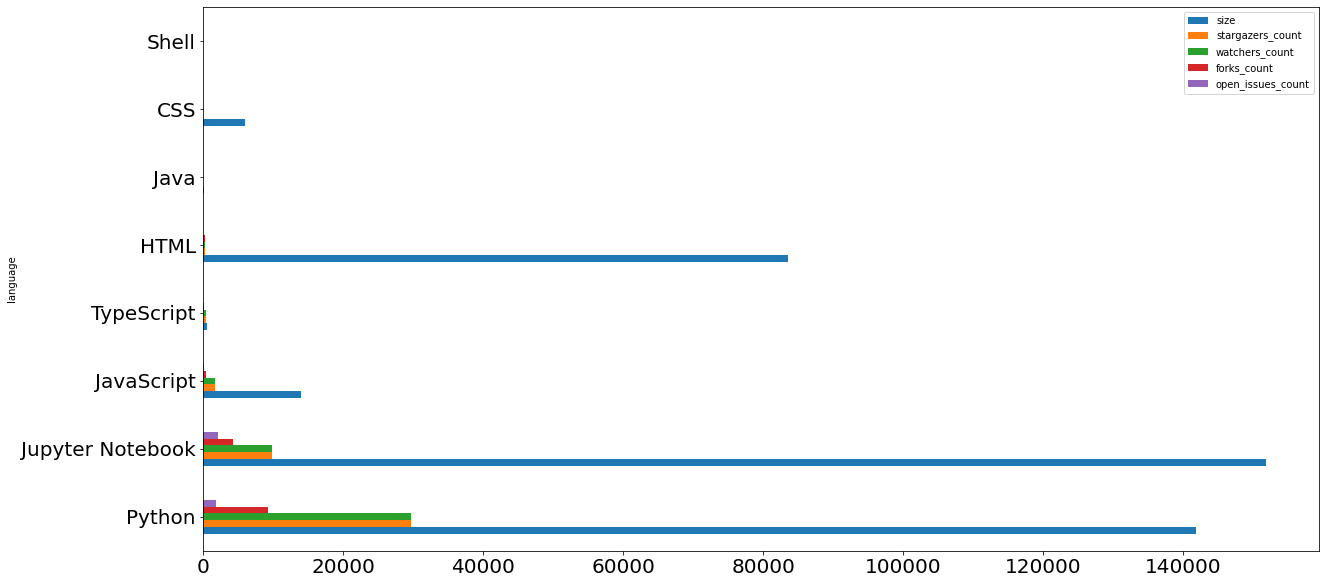

In [60]:
language_totals.plot.barh(figsize=(20, 10), fontsize=20)

---
## Utility

Check you GitHub API limits:

In [ ]:
api.rate_limit.get()

If the API limit is reached, load from included csv:

In [20]:
# If you need to export the dataframe to a csv file, you can use the following
# df.to_csv("jupyter_repos.csv")
pd.read_csv("jupyter_repos.csv")

,Unnamed: 0,name,html_url,description,homepage,size,stargazers_count,watchers_count,language,forks_count,open_issues_count,license,topics,default_branch
0,0,nbviewer,https://github.com/jupyter/nbviewer,nbconvert as a web service: Render Jupyter Not...,https://nbviewer.jupyter.org,12473,2015,2015,Python,523,171,"{'key': 'other', 'name': 'Other', 'spdx_id': '...","['jupyter', 'jupyter-notebook', 'nbconvert']",main
1,1,nbconvert-examples,https://github.com/jupyter/nbconvert-examples,Examples that illustrate how nbconvert can be ...,NaN,1678,149,149,Jupyter Notebook,82,9,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
2,2,colaboratory,https://github.com/jupyter/colaboratory,"[deprecated] Jupyter CoLaboratory, goto google...",https://colab.research.google.com,1063,734,734,JavaScript,126,0,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
3,3,jupyter.github.io,https://github.com/jupyter/jupyter.github.io,Project Jupyter's home on the World Wide Web,https://jupyter.org,28975,154,154,HTML,157,18,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...","['homepage', 'jekyll', 'jupyter', 'jupyter-not...",master
4,4,design,https://github.com/jupyter/design,Design related materials for Project Jupyter,NaN,52446,77,77,HTML,57,18,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,notebook_shim,https://github.com/jupyter/notebook_shim,A shim layer for notebook traits and config,NaN,30,3,3,Python,8,2,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
78,78,try-jupyter,https://github.com/jupyter/try-jupyter,"A JupyterLite deployment to try JupyterLab, Ju...",https://jupyter.org/try-jupyter,39963,4,4,Jupyter Notebook,10,2,NaN,"['ipython', 'jupyter', 'jupyterlab']",main
79,79,team-compass-template,https://github.com/jupyter/team-compass-template,A template for team-compass repositories,NaN,46,0,0,Python,2,1,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
80,80,kernels-team-compass,https://github.com/jupyter/kernels-team-compass,The team-compass for the Jupyter Kernels Subpr...,https://kernels-team-compass.readthedocs.io/en...,22,2,2,NaN,2,0,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
